<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Como ejemplo se utilizará como corpus un dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2026k  100 2026k    0     0  3381k      0 --:--:-- --:--:-- --:--:-- 3388k
"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [7]:
# Posibles bandas
os.listdir("./songs_dataset/")

['songs_dataset']

In [2]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

C:\Users\Zeus\AppData\Local\Temp\ipykernel_12648\3849064916.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [3]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


### Elegir el tamaño del contexto

In [2]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [5]:
# cada verso lo guardamos en una lista
text = list(df.loc[:,0])
text

['Yesterday, all my troubles seemed so far away',
 "Now it looks as though they're here to stay",
 "Oh, I believe in yesterday Suddenly, I'm not half the man I used to be",
 "There's a shadow hanging over me.",
 "Oh, yesterday came suddenly Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 "Oh, I believe in yesterday Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 'Oh, I believe in yesterday',
 'Mm mm mm mm mm mm mm When I find myself in times of trouble, Mother Mary comes to me',
 'Speaking words of wisdom, let it be',
 'And in my hour of darkness she is standing right in front of me',
 'Speaking words of wisdom, let it be',
 'Let it be, let it be, let it be, let it be',
 'Whisper words of wisdom, let it be And when

In [6]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [7]:
text[0]

'Yesterday, all my troubles seemed so far away'

In [8]:
segmented_sentences[0]

['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away']

In [9]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([ 29., 305., 221., 523., 293.,  72., 180.,  97.,  42.,  39.,  22.,
         12.,   4.,   3.,   0.,   0.,   2.,   1.,   0.,   1.]),
 array([ 1.  ,  2.65,  4.3 ,  5.95,  7.6 ,  9.25, 10.9 , 12.55, 14.2 ,
        15.85, 17.5 , 19.15, 20.8 , 22.45, 24.1 , 25.75, 27.4 , 29.05,
        30.7 , 32.35, 34.  ]),
 <BarContainer object of 20 artists>)

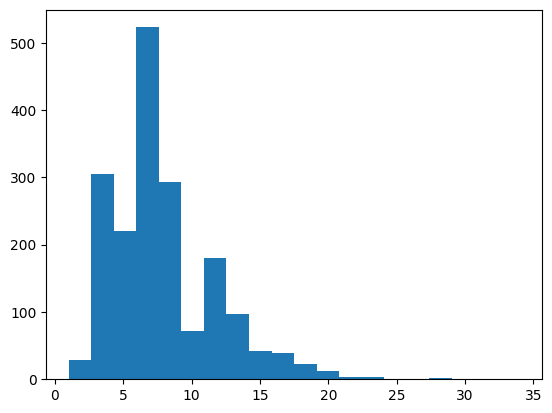

In [10]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [12]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 12


###  Tokenizar

In [13]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [14]:
tokenized_sentences[0]

[200, 10, 12, 907, 908, 42, 909, 121]

In [15]:
segmented_sentences[0]

['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [16]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

\Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

Por ejemplo, si tenemos el texto *La bella y graciosa moza marchóse a lavar la ropa* y nuestro contexto es de 5 palabras, tendremos:

- *La bella y graciosa moza*
- *bella y graciosa moza marchóse*
- *y graciosa moza marchóse a*
- *graciosa moza marchóse a lavar*
- *moza marchóse a lavar la*
- *marchóse a lavar la ropa*

In [17]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [18]:
len(tok_sent)

1957

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [19]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [20]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [21]:
train_seqs.shape

(15325, 13)

In [23]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [24]:
y.shape

(15325, 12)

In [25]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'to',
 5: 'and',
 6: 'love',
 7: 'a',
 8: 'me',
 9: 'in',
 10: 'all',
 11: 'nah',
 12: 'my',
 13: 'it',
 14: 'know',
 15: 'be',
 16: 'that',
 17: 'of',
 18: 'on',
 19: 'she',
 20: 'is',
 21: 'say',
 22: 'now',
 23: 'oh',
 24: 'yeah',
 25: 'your',
 26: 'get',
 27: "don't",
 28: 'back',
 29: 'let',
 30: 'with',
 31: 'her',
 32: 'can',
 33: "it's",
 34: 'do',
 35: "i'm",
 36: 'when',
 37: 'come',
 38: 'will',
 39: 'he',
 40: 'but',
 41: 'for',
 42: 'so',
 43: 'need',
 44: 'there',
 45: 'like',
 46: 'no',
 47: 'together',
 48: "i'll",
 49: 'see',
 50: 'was',
 51: 'never',
 52: 'we',
 53: 'down',
 54: 'way',
 55: 'if',
 56: 'want',
 57: 'out',
 58: 'hey',
 59: 'one',
 60: 'got',
 61: 'go',
 62: 'well',
 63: "can't",
 64: 'girl',
 65: 'good',
 66: 'his',
 67: 'sun',
 68: 'they',
 69: 'home',
 70: 'hello',
 71: 'day',
 72: 'are',
 73: 'ah',
 74: 'right',
 75: 'little',
 76: 'at',
 77: 'from',
 78: 'man',
 79: 'here',
 80: 'help',
 81: 'gonna',
 82: 'have',
 

In [26]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1628

In [27]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'you': 1, 'i': 2, 'the': 3, 'to': 4, 'and': 5, 'love': 6, 'a': 7, 'me': 8, 'in': 9, 'all': 10, 'nah': 11, 'my': 12, 'it': 13, 'know': 14, 'be': 15, 'that': 16, 'of': 17, 'on': 18, 'she': 19, 'is': 20, 'say': 21, 'now': 22, 'oh': 23, 'yeah': 24, 'your': 25, 'get': 26, "don't": 27, 'back': 28, 'let': 29, 'with': 30, 'her': 31, 'can': 32, "it's": 33, 'do': 34, "i'm": 35, 'when': 36, 'come': 37, 'will': 38, 'he': 39, 'but': 40, 'for': 41, 'so': 42, 'need': 43, 'there': 44, 'like': 45, 'no': 46, 'together': 47, "i'll": 48, 'see': 49, 'was': 50, 'never': 51, 'we': 52, 'down': 53, 'way': 54, 'if': 55, 'want': 56, 'out': 57, 'hey': 58, 'one': 59, 'got': 60, 'go': 61, 'well': 62, "can't": 63, 'girl': 64, 'good': 65, 'his': 66, 'sun': 67, 'they': 68, 'home': 69, 'hello': 70, 'day': 71, 'are': 72, 'ah': 73, 'right': 74, 'little': 75, 'at': 76, 'from': 77, 'man': 78, 'here': 79, 'help': 80, 'gonna': 81, 'have': 82, 'not': 83, 'world': 84, 'going': 85, 'what': 86, 'still': 87, 'how': 88, 'too': 89

In [29]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'yesterday': 10, 'my': 134, 'all': 177, 'far': 1, 'seemed': 1, 'troubles': 1, 'so': 61, 'away': 21, 'now': 90, 'here': 33, 'as': 25, 'though': 11, "they're": 5, 'to': 307, 'stay': 7, 'looks': 2, 'it': 125, 'in': 186, 'used': 1, 'i': 400, 'oh': 77, 'not': 32, "i'm": 66, 'be': 108, 'believe': 15, 'man': 34, 'the': 376, 'suddenly': 3, 'half': 1, "there's": 14, 'me': 219, 'over': 5, 'a': 270, 'shadow': 1, 'hanging': 1, 'came': 11, "don't": 74, 'she': 90, "wouldn't": 4, 'say': 76, 'had': 19, 'know': 132, 'why': 20, 'go': 38, 'such': 9, 'game': 3, 'play': 10, 'something': 13, 'for': 62, 'an': 15, 'was': 48, 'easy': 9, 'said': 14, 'long': 25, 'wrong': 6, 'love': 181, 'hide': 13, 'need': 51, 'place': 10, 'trouble': 1, 'mm': 3, 'find': 10, 'times': 5, 'mary': 2, 'comes': 20, 'when': 71, 'myself': 3, 'of': 109, 'mother': 2, 'speaking': 4, 'let': 55, 'words': 14, 'wisdom': 7, 'and': 311, 'right': 25, 'hour': 1, 'is': 89, 'front': 1, 'darkness': 1, 'standing': 13, 'livi


### Definir el modelo

In [30]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          81450     
                                                                 
 lstm (LSTM)                 (None, None, 100)         60400     
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         80400     
                                                                 
 dense (Dense)               (None, None, 1629)        164529    
                                                                 
Total params: 386,779
Trainable params: 386,779
Non-trainable params: 0
_________________________________________________________________


Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [31]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          #self.model.save("my_model")
          #self.model.save("my_model_LSTM_word.keras")
          self.model.save("my_model_GRU_word.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [32]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
235/240 [============================>.] - ETA: 0s - loss: 3.8756
 mean perplexity: 240028.9686305552 



INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved new model!
240/240 [==============================] - 12s 33ms/step - loss: 3.8644
Epoch 2/20
238/240 [============================>.] - ETA: 0s - loss: 2.9500
 mean perplexity: 488882.90572485514 

240/240 [==============================] - 3s 11ms/step - loss: 2.9495
Epoch 3/20
237/240 [============================>.] - ETA: 0s - loss: 2.7480
 mean perplexity: 186001.1482381186 



INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved new model!
240/240 [==============================] - 7s 30ms/step - loss: 2.7471
Epoch 4/20
237/240 [============================>.] - ETA: 0s - loss: 2.6031
 mean perplexity: 90723.26467087041 



INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved new model!
240/240 [==============================] - 7s 31ms/step - loss: 2.6031
Epoch 5/20
235/240 [============================>.] - ETA: 0s - loss: 2.4836
 mean perplexity: 124878.00626961613 

240/240 [==============================] - 3s 11ms/step - loss: 2.4831
Epoch 6/20
239/240 [============================>.] - ETA: 0s - loss: 2.3773
 mean perplexity: 315075.7253668707 

240/240 [==============================] - 3s 11ms/step - loss: 2.3770
Epoch 7/20
237/240 [============================>.] - ETA: 0s - loss: 2.2771
 mean perplexity: 243338.0712658481 

240/240 [==============================] - 3s 10ms/step - loss: 2.2757
Epoch 8/20
239/240 [============================>.] - ETA: 0s - loss: 2.1750
 mean perplexity: 235592.43548632844 

240/240 [==============================] - 2s 10ms/step - loss: 2.1749
Epoch 9/20
237/240 [============================>.] - ETA: 0s - loss: 2.0754
 mean perplexity: 355246.23369690654 

Stopping training...
240/240 [====================

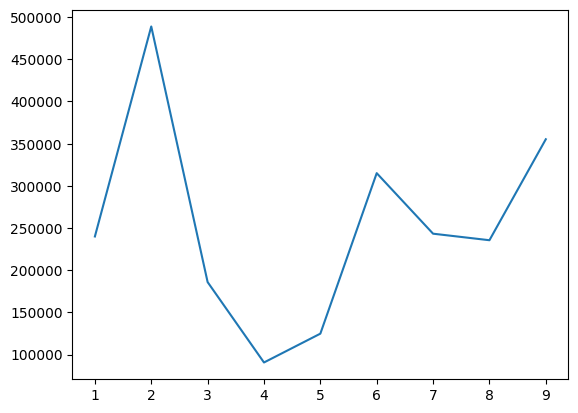

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [34]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model')


### Predicción de próxima palabra

In [35]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [36]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

C:\Users\Zeus\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 25ms/step
Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [37]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [38]:
input_text='hey jude don\'t'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 28ms/step


"hey jude don't the little day's night and i be a hard night"

###  Beam search y muestreo aleatorio

In [43]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [44]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [41]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="when i find myself in times",temp=1,mode='sto')

In [42]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 18)

In [43]:
# veamos las salidas
decode(salidas[0])

['when i find myself in times a way handy night and']

### Desafio 3--- MOdelo de lenguaje Word

Se utilizara La Metamorfosis de Franz Kafka del sitio www.textos.info

In [5]:
import urllib.request
import re
url = "https://www.textos.info/franz-kafka/la-metamorfosis/pdf"

urllib.request.urlretrieve(url, "la-metamorfosis.pdf")
print("Archivo PDF descargado exitosamente.")

Archivo PDF descargado exitosamente.


In [6]:
#convertir archivo pfd a texto
import fitz
def pdf_to_txt(pdf_path, txt_path):
    pdf_document = fitz.open(pdf_path)
    text = ""
    for page in pdf_document:
        text += page.get_text()
    with open(txt_path, "w", encoding="utf-8") as txt_file:
        txt_file.write(text)

    print(f"Archivo convertido a TXT almacenado en {txt_path}")
pdf_to_txt("la-metamorfosis.pdf", "la-metamorfosis.txt")  # se genera nuevo archivo modificado convertido a txt

Archivo convertido a TXT almacenado en la-metamorfosis.txt


In [7]:
# Leer el archivo de texto
with open("la-metamorfosis.txt", "r", encoding="utf-8") as file:
    text = file.read()
# Normalizacion de  texto a minusculas, eliminacion de caracterias diferentes a alfabeticos
text = text.lower()
text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
text = re.sub(r'[!?]', '', text)  
text = re.sub(r' +', ' ', text)
archivo=open("la-metamorfosis_mod.txt", "w", encoding="utf-8") 
archivo.write(text)
archivo.close()

In [8]:
# Mostrar el texto extraído (opcional)
print(text[:1000])  # Muestra los primeros 1000 caracteres


la metamorfosis
franz kafka
textosinfo
biblioteca digital abierta

texto núm 
título la metamorfosis
autor franz kafka
etiquetas novela corta
editor edu robsy
fecha de creación de mayo de 
fecha de modificación de noviembre de 
edita textosinfo
maison carrée
c des ramal 
 alayor menorca
islas baleares
españa
más textos disponibles en httpwwwtextosinfo

i
cuando gregorio samsa se despertó una mañana después de un sueño 
intranquilo se encontró sobre su cama convertido en un monstruoso 
insecto estaba tumbado sobre su espalda dura y en forma de caparazón 
y al levantar un poco la cabeza veía un vientre abombado parduzco 
dividido por partes duras en forma de arco sobre cuya protuberancia 
apenas podía mantenerse el cobertor a punto ya de resbalar al suelo sus 
muchas patas ridículamente pequeñas en comparación con el resto de su 
tamaño le vibraban desamparadas ante los ojos
qué me ha ocurrido pensó
no era un sueño su habitación una auténtica habitación humana si bien 
algo pequeña perm

In [5]:
df = pd.read_csv('la-metamorfosis_mod.txt', sep='/n', header=None, names=['sentence'])
print(df.head(20))
     

                                             sentence
0                                     la metamorfosis
1                                         franz kafka
2                                          textosinfo
3                          biblioteca digital abierta
4                                           texto núm
5                              título la metamorfosis
6                                   autor franz kafka
7                              etiquetas novela corta
8                                    editor edu robsy
9                        fecha de creación de mayo de
10              fecha de modificación de noviembre de
11                                   edita textosinfo
12                                      maison carrée
13                                        c des ramal
14                                     alayor menorca
15                                     islas baleares
16                                             españa
17        más textos disponi

C:\Users\Zeus\AppData\Local\Temp\ipykernel_29888\3552435788.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('la-metamorfosis_mod.txt', sep='/n', header=None, names=['sentence'])


In [6]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1849


Elegir tamaño del contexto

In [4]:

# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [7]:
# cada verso lo guardamos en una lista
text = list(df.iloc[:,0])
text

['la metamorfosis',
 'franz kafka',
 'textosinfo',
 'biblioteca digital abierta',
 'texto núm',
 'título la metamorfosis',
 'autor franz kafka',
 'etiquetas novela corta',
 'editor edu robsy',
 'fecha de creación de mayo de',
 'fecha de modificación de noviembre de',
 'edita textosinfo',
 'maison carrée',
 'c des ramal',
 'alayor menorca',
 'islas baleares',
 'españa',
 'más textos disponibles en httpwwwtextosinfo',
 'i',
 'cuando gregorio samsa se despertó una mañana después de un sueño',
 'intranquilo se encontró sobre su cama convertido en un monstruoso',
 'insecto estaba tumbado sobre su espalda dura y en forma de caparazón',
 'y al levantar un poco la cabeza veía un vientre abombado parduzco',
 'dividido por partes duras en forma de arco sobre cuya protuberancia',
 'apenas podía mantenerse el cobertor a punto ya de resbalar al suelo sus',
 'muchas patas ridículamente pequeñas en comparación con el resto de su',
 'tamaño le vibraban desamparadas ante los ojos',
 'qué me ha ocurrido

In [8]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [9]:

segmented_sentences[110]

['voz',
 'que',
 'evidentemente',
 'era',
 'la',
 'suya',
 'pero',
 'en',
 'la',
 'cual',
 'como',
 'desde',
 'lo',
 'más']

In [10]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([ 42.,  16.,  20.,  11.,   0.,  20.,  17.,  18.,  28.,   0.,  89.,
        173., 327., 378.,   0., 349., 232.,  96.,  22.,  11.]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ,  5.8,  6.6,  7.4,  8.2,  9. ,
         9.8, 10.6, 11.4, 12.2, 13. , 13.8, 14.6, 15.4, 16.2, 17. ]),
 <BarContainer object of 20 artists>)

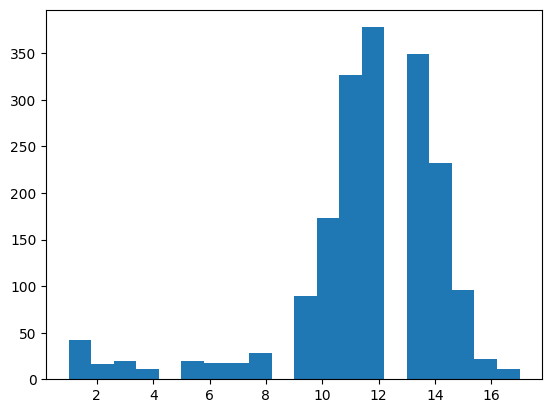

In [11]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [12]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil.

# el -1 es porque el último token será el target
# Reducimos la ventana de contexto por problemas con la memoria del GPU
max_context_size = int(np.percentile(length_sentences, 50)-1)
print(f'max_context_size: {max_context_size}')

max_context_size: 11


Tokenizar

In [13]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [14]:
tokenized_sentences[110]

[97, 3, 997, 39, 1, 998, 19, 6, 1, 201, 26, 61, 20, 24]

In [15]:
segmented_sentences[100]

['y',
 'es',
 'que',
 'en',
 'este',
 'caso',
 'no',
 'tendría',
 'un',
 'poco',
 'de',
 'razón',
 'gregorio',
 'a']

Organizando y estructurando el dataset

In [16]:
#En este punto tenemos en la variable tokenized_sentences los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos 
# para medir la calidad de la generación de secuencias con la métrica de Perplejidad
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)     

In [17]:
#Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. 
# Este paso puede obviarse si el tamaño de contexto máximo es muy grande.
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)
     

In [18]:
len(tok_sent)

2463

In [19]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [20]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [21]:
train_seqs.shape

(25282, 12)

In [22]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [23]:
y.shape

(25282, 11)

In [24]:
# Palabras del vocabulario
tok.index_word

{1: 'la',
 2: 'de',
 3: 'que',
 4: 'y',
 5: 'el',
 6: 'en',
 7: 'a',
 8: 'se',
 9: 'con',
 10: 'no',
 11: 'su',
 12: 'gregorio',
 13: 'por',
 14: 'un',
 15: 'había',
 16: 'los',
 17: 'una',
 18: 'las',
 19: 'pero',
 20: 'lo',
 21: 'al',
 22: 'del',
 23: 'ya',
 24: 'más',
 25: 'para',
 26: 'como',
 27: 'le',
 28: 'hermana',
 29: 'habitación',
 30: 'padre',
 31: 'si',
 32: 'todo',
 33: 'sus',
 34: 'madre',
 35: 'estaba',
 36: 'hacia',
 37: 'puerta',
 38: 'sin',
 39: 'era',
 40: 'sobre',
 41: 'tenía',
 42: 'porque',
 43: 'cuando',
 44: 'él',
 45: 'podía',
 46: 'ahora',
 47: 'vez',
 48: 'sólo',
 49: 'es',
 50: 'tiempo',
 51: 'ella',
 52: 'apoderado',
 53: 'señor',
 54: 'dijo',
 55: 'otra',
 56: 'hubiese',
 57: 'después',
 58: 'poco',
 59: 'cabeza',
 60: 'mismo',
 61: 'desde',
 62: 'esta',
 63: 'habían',
 64: 'muy',
 65: 'momento',
 66: 'samsa',
 67: 'qué',
 68: 'ni',
 69: 'familia',
 70: 'cama',
 71: 'forma',
 72: 'sí',
 73: 'incluso',
 74: 'así',
 75: 'bien',
 76: 'allí',
 77: 'entonces',

In [25]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3661

In [26]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'la': 1, 'de': 2, 'que': 3, 'y': 4, 'el': 5, 'en': 6, 'a': 7, 'se': 8, 'con': 9, 'no': 10, 'su': 11, 'gregorio': 12, 'por': 13, 'un': 14, 'había': 15, 'los': 16, 'una': 17, 'las': 18, 'pero': 19, 'lo': 20, 'al': 21, 'del': 22, 'ya': 23, 'más': 24, 'para': 25, 'como': 26, 'le': 27, 'hermana': 28, 'habitación': 29, 'padre': 30, 'si': 31, 'todo': 32, 'sus': 33, 'madre': 34, 'estaba': 35, 'hacia': 36, 'puerta': 37, 'sin': 38, 'era': 39, 'sobre': 40, 'tenía': 41, 'porque': 42, 'cuando': 43, 'él': 44, 'podía': 45, 'ahora': 46, 'vez': 47, 'sólo': 48, 'es': 49, 'tiempo': 50, 'ella': 51, 'apoderado': 52, 'señor': 53, 'dijo': 54, 'otra': 55, 'hubiese': 56, 'después': 57, 'poco': 58, 'cabeza': 59, 'mismo': 60, 'desde': 61, 'esta': 62, 'habían': 63, 'muy': 64, 'momento': 65, 'samsa': 66, 'qué': 67, 'ni': 68, 'familia': 69, 'cama': 70, 'forma': 71, 'sí': 72, 'incluso': 73, 'así': 74, 'bien': 75, 'allí': 76, 'entonces': 77, 'cómo': 78, 'también': 79, 'este': 80, 'parte': 81, 'hacía': 82, 'antes': 8

In [27]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'la': 797, 'metamorfosis': 3, 'franz': 4, 'kafka': 6, 'textosinfo': 2, 'biblioteca': 1, 'digital': 1, 'abierta': 12, 'núm': 1, 'texto': 1, 'título': 1, 'autor': 4, 'corta': 2, 'etiquetas': 1, 'novela': 2, 'robsy': 1, 'editor': 1, 'edu': 1, 'de': 771, 'fecha': 2, 'creación': 1, 'mayo': 1, 'noviembre': 1, 'modificación': 1, 'edita': 1, 'carrée': 1, 'maison': 1, 'des': 1, 'ramal': 1, 'c': 1, 'menorca': 1, 'alayor': 1, 'islas': 1, 'baleares': 1, 'españa': 1, 'en': 454, 'disponibles': 1, 'más': 122, 'textos': 1, 'httpwwwtextosinfo': 1, 'i': 1, 'sueño': 7, 'después': 37, 'cuando': 63, 'mañana': 22, 'un': 191, 'despertó': 4, 'se': 428, 'gregorio': 261, 'samsa': 32, 'una': 169, 'intranquilo': 1, 'su': 261, 'cama': 32, 'encontró': 4, 'monstruoso': 1, 'convertido': 4, 'sobre': 71, 'y': 607, 'caparazón': 2, 'estaba': 81, 'insecto': 1, 'tumbado': 12, 'dura': 2, 'forma': 32, 'espalda': 17, 'parduzco': 2, 'veía': 15, 'levantar': 5, 'vientre': 5, 'poco': 36, 'abombado': 1,

### Definir el modelo   ----- LSTM

In [33]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          183100    
                                                                 
 lstm (LSTM)                 (None, None, 100)         60400     
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         80400     
                                                                 
 dense (Dense)               (None, None, 3662)        369862    
                                                                 
Total params: 693,762
Trainable params: 693,762
Non-trainable params: 0
_________________________________________________________________


Entrenamiento

In [34]:
# fiteamos
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
396/396 [==============================] - ETA: 0s - loss: 4.5021
 mean perplexity: 727637.1408422744 

Saved new model!
396/396 [==============================] - 12s 14ms/step - loss: 4.5021
Epoch 2/20
391/396 [============================>.] - ETA: 0s - loss: 3.6281
 mean perplexity: 87487.56701106705 

Saved new model!
396/396 [==============================] - 5s 12ms/step - loss: 3.6256
Epoch 3/20
394/396 [============================>.] - ETA: 0s - loss: 3.4364
 mean perplexity: 20162.608184197732 

Saved new model!
396/396 [==============================] - 5s 12ms/step - loss: 3.4366
Epoch 4/20
391/396 [============================>.] - ETA: 0s - loss: 3.3033
 mean perplexity: 43761.33422176201 

396/396 [==============================] - 4s 11ms/step - loss: 3.3021
Epoch 5/20
392/396 [============================>.] - ETA: 0s - loss: 3.1834
 mean perplexity: 40922.068761318245 

396/396 [==============================] - 4s 11ms/step - loss: 3.1821
Epoch 6/20
394/3

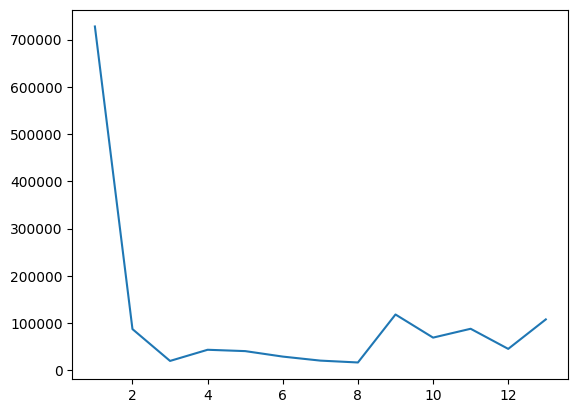

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [37]:

# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model_LSTM_word.keras')

Predicción de próxima palabra

In [38]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [39]:

import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

C:\Users\Zeus\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 23ms/step
Keyboard interruption in main thread... closing server.


Generación de secuencias

In [38]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text
     


In [52]:
input_text='se dijo Gregorio para sus'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)


1/1 [==============================] - 0s 28ms/step


'se dijo Gregorio para sus adentros a su habitación y no se podía dado la'

In [55]:
input_text='Gregorio ser despedido'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 24ms/step


'Gregorio ser despedido a pesar de que de las dos de de si'

In [56]:
input_text='exclamó entonces el apoderado'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 25ms/step


'exclamó entonces el apoderado se había imaginado que el padre y se dirigió por'

In [65]:
input_text='Allí permaneció durante'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 22ms/step


'Allí permaneció durante la noche de la madre y se había ocurrió la'

Beam search y muestreo aleatorio

In [66]:
def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [67]:
from scipy.special import softmax

def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams]
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp))
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)


  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):


    encoded = encode(input)

    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    
    vocab_size = y_hat.shape[0]

    
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

  
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

       
        input_update = np.array([hist[i+1:]]).copy()

        
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [196]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=5,input="Gregorio había",temp=2,mode='det')

In [197]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 16)

In [198]:

# veamos las salidas
decode(salidas[0])

['gregorio había llegado a la habitación de']

### Exploraion con modelo   ----- GRU

In [28]:
from keras.layers import GRU
model1 = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model1.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model1.add(GRU(100, return_sequences=True))
model1.add(Dropout(0.2))

model1.add(GRU(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model1.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model1.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          183100    
                                                                 
 gru (GRU)                   (None, None, 100)         45600     
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 gru_1 (GRU)                 (None, None, 100)         60600     
                                                                 
 dense (Dense)               (None, None, 3662)        369862    
                                                                 
Total params: 659,162
Trainable params: 659,162
Non-trainable params: 0
_________________________________________________________________


Entrenamiento GRU 

In [32]:
# fiteamos
history_ppl = []
hist = model1.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
395/396 [============================>.] - ETA: 0s - loss: 4.1886
 mean perplexity: 83208.07061281342 

Saved new model!
396/396 [==============================] - 9s 12ms/step - loss: 4.1886
Epoch 2/20
395/396 [============================>.] - ETA: 0s - loss: 3.5005
 mean perplexity: 12952.691193326738 

Saved new model!
396/396 [==============================] - 4s 11ms/step - loss: 3.5005
Epoch 3/20
394/396 [============================>.] - ETA: 0s - loss: 3.3052
 mean perplexity: 12630.568262938896 

Saved new model!
396/396 [==============================] - 4s 11ms/step - loss: 3.3052
Epoch 4/20
393/396 [============================>.] - ETA: 0s - loss: 3.1457
 mean perplexity: 19156.743325508665 

396/396 [==============================] - 4s 11ms/step - loss: 3.1454
Epoch 5/20
396/396 [==============================] - ETA: 0s - loss: 3.0083
 mean perplexity: 10720.38588432209 

Saved new model!
396/396 [==============================] - 4s 11ms/step - loss: 3.0083

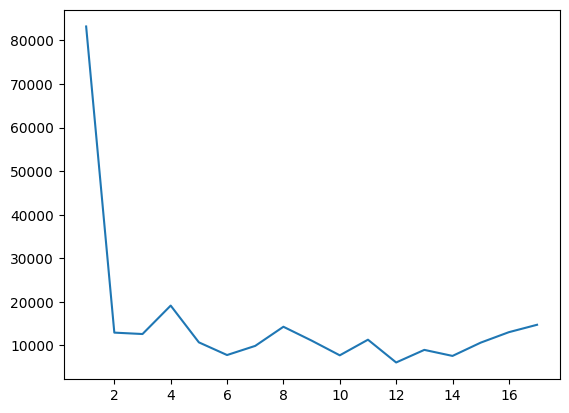

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [36]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model_GRU_word.keras')

Predicción de próxima palabra

In [35]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [37]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

C:\Users\Zeus\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 22ms/step
Keyboard interruption in main thread... closing server.


Generación de secuencias GRU

In [39]:
input_text='se dijo Gregorio para sus'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 22ms/step


'se dijo Gregorio para sus adentros pero no se abrió que ella podía entrar a'

In [40]:
input_text='Gregorio ser despedido'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 24ms/step


'Gregorio ser despedido para llamar la atención de la cama y se deslizó'

In [41]:
input_text='exclamó entonces el apoderado'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 24ms/step


'exclamó entonces el apoderado se encontraba a su respecto en las huéspedes del todo'

In [42]:
input_text='Allí permaneció durante'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 21ms/step


'Allí permaneció durante la noche no estaba aquí con indolencia el violín y'

Beam search y muestreo aleatorio

In [51]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=5,input="Gregorio había",temp=2,mode='det')

In [52]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 16)

In [53]:
# veamos las salidas
decode(salidas[0])

['gregorio había pensado a sus padres y']

##### Se hizo la evaluacion de las alternativas, LSTM y GRU
##### Se cambio el corpus del ejercicio CHAR debido a que generaba errores de memoria en la GPU de esta forma no muestrar el corpus o perder la ganancia de Augmentation
##### Se observa que  el modelo LSTM presenta resultados un poco mejores que GRU , para GRU algunos test dieron resultados sin sentido se hizo ajuste de mode y temperatura.
##### para este caso la perplejidad tuvo mejor resultaod para el modelo LSTM
#### Para GRU con mode deterministico y temp 2 mejoro notablemente y secuencias de salida empezaron a dar resultados logicos.
#### En el archivo pdf adjunto en el repo se muestran las secuencia obtenidas por gradio ademas de los modelos entrenados.